In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, Sequential
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import vgg16
from turtle import shape
import tensorflow_datasets as tfds
import numpy as np
import PIL
import os

In [2]:
data_dir = 'Train'

 
img_height = 360
img_width = 360
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_dir = 'Test'

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, seed=123, image_size=(224, 224), shuffle=False, batch_size=32)

class_names = train_ds.class_names

num_classes = len(class_names)


Found 382 files belonging to 4 classes.
Using 306 files for training.
Found 382 files belonging to 4 classes.
Using 76 files for validation.
Found 120 files belonging to 4 classes.


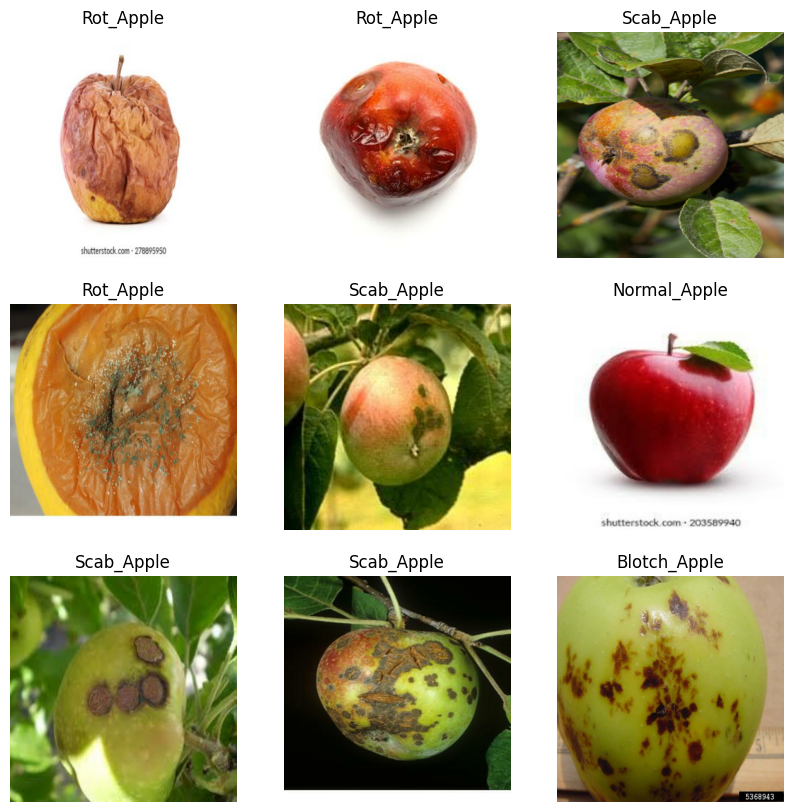

In [3]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

    # plt.show()


In [4]:
print(class_names)
# klasses waarin de apple zit.
# 0= Blotch Apple 
# 1= Normal Apple 
# 2= Rot Apple 
# 3= Scab Apple 

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']


In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 3)
(32,)


In [6]:

data_augmentation = keras.Sequential(
  [ 
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(45),
    layers.RandomZoom(.4),
  ]
)


In [7]:
images = tf.cast(tf.expand_dims(images, 0), tf.float32)

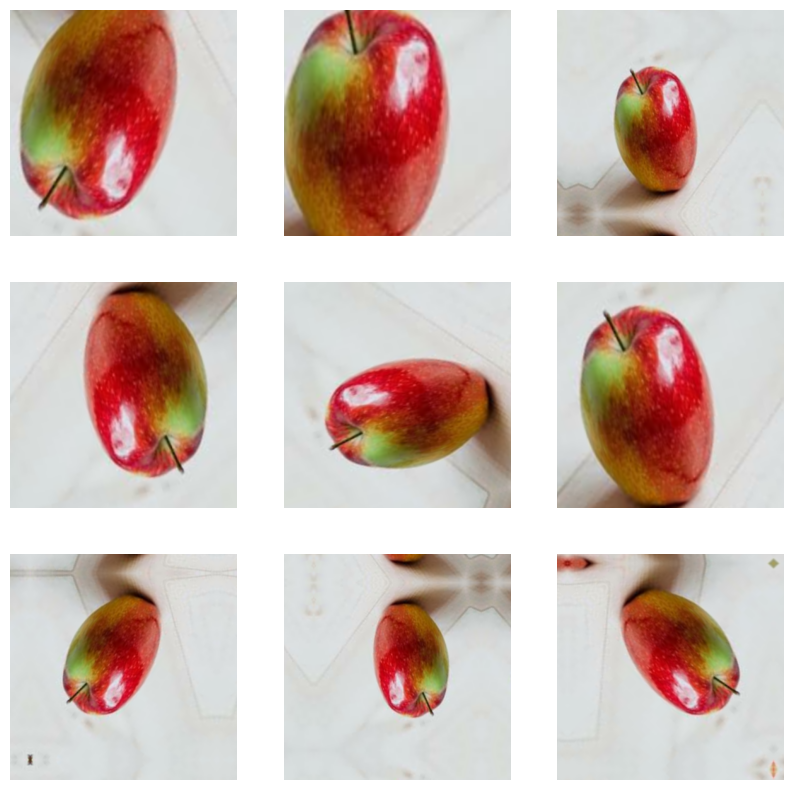

In [8]:
plt.figure(figsize=(10, 10))

image, label = next(iter(train_ds))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(image,training=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [9]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
#Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [12]:
"""
model = keras.models.Sequential()

model.add(layers.Input(shape=(360, 360, 3)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='softmax'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.2))

model.add(layers.Dense(4, activation='relu'))

model.summary()

num_classes = len(class_names)

"""
num_classes = len(class_names)

modelx = Sequential([
    layers.Rescaling(1./255, input_shape=(360, 360, 3)),
    layers.Conv2D(16, 3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4),
    layers.Dense(num_classes),
    ])

modelx.summary()

""""
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(360,360,3)),
    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='softmax'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4),
    ])

model.summary()

"""


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 360, 360, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 360, 360, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 180, 180, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 88, 88, 64)       

'"\nmodel = tf.keras.models.Sequential([\n    tf.keras.layers.Input(shape=(360,360,3)),\n    tf.keras.layers.Conv2D(16, 3, padding= \'same\', activation=\'relu\'),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(16, 3, padding= \'same\', activation=\'softmax\'),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(16, 3, padding= \'same\', activation=\'relu\'),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Dense(4),\n    ])\n\nmodel.summary()\n\n'

In [13]:
modelx.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
epochs=15
history = modelx.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
10/10 [==============================] - 15s 1s/step - loss: 1.3566 - accuracy: 0.3399 - val_loss: 1.3292 - val_accuracy: 0.2368
Epoch 2/15
10/10 [==============================] - 14s 1s/step - loss: 1.2325 - accuracy: 0.4673 - val_loss: 1.1160 - val_accuracy: 0.5263
Epoch 3/15
10/10 [==============================] - 14s 1s/step - loss: 1.0130 - accuracy: 0.6111 - val_loss: 0.8770 - val_accuracy: 0.6711
Epoch 4/15
10/10 [==============================] - 19s 2s/step - loss: 0.7562 - accuracy: 0.7386 - val_loss: 0.8772 - val_accuracy: 0.7105
Epoch 5/15
10/10 [==============================] - 15s 1s/step - loss: 0.7450 - accuracy: 0.7157 - val_loss: 0.8498 - val_accuracy: 0.6711
Epoch 6/15
10/10 [==============================] - 14s 1s/step - loss: 0.6058 - accuracy: 0.7810 - val_loss: 1.2441 - val_accuracy: 0.6316
Epoch 7/15
10/10 [==============================] - 14s 1s/step - loss: 0.6738 - accuracy: 0.7582 - val_loss: 1.0010 - val_accuracy: 0.6316
Epoch 8/15
10/10 [==

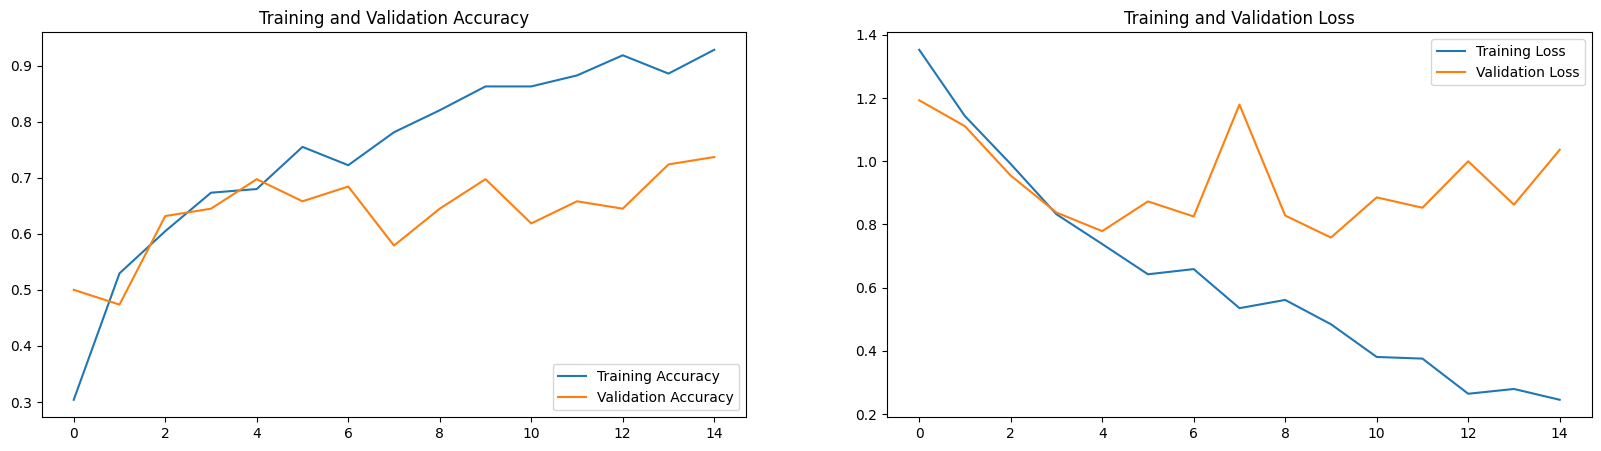

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
modelx.evaluate(train_ds)

10/10 [==============================] - 6s 533ms/step - loss: 0.2442 - accuracy: 0.9052


[0.24421803653240204, 0.9052287340164185]

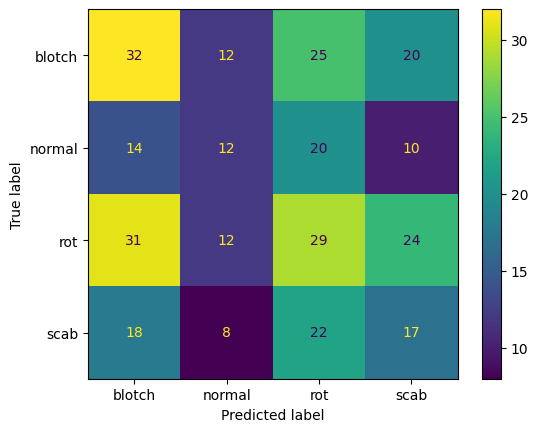

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


batchPredictions = modelx.predict(train_ds)

predicted_categories = tf.argmax(batchPredictions, axis=1)

true_categories = tf.concat([y for x, y in train_ds], axis=0)

cm = confusion_matrix(true_categories, predicted_categories)

cmd = ConfusionMatrixDisplay(cm, display_labels=['blotch','normal','rot','scab'])
cmd.plot()
plt.show() 
